# <font size="8">Welcome to sedcreator! </font>

<font size="4">Before we start make sure you have `sedcreator` installed. It can be installed by simply typing:</font>

-------
```pip install sedcreator```
-------

<font size="4"> In some distributions you may need to type `pip3` instead, so it would be:</font>
    

```pip3 install sedcreator```
-------

-------

<font size="4">`sedcreator` is composed of two main classes `SedFluxer` and `SedFitter` to construct and fit **Spectral Energy Distributions (SEDs)**. In this notebook we will walk you through the main features of `SedFluxer`. Please check out the other examples for more.
    
*The main purpose of `SedFluxer` is to help us to measure fluxes from astronomical images (as the name may have suggested). It includes a number of functions to retrieve the flux (by means of aperture photometry) and useful information from the data and to plot the used image together with the chosen central coordinates and aperture size (see below for more details).*

If you make use of sedcreator in your work or as a dependency of other package, please include the following citation/acknowledgment:</font> https://sedcreator.readthedocs.io/en/latest/citation.html

## The full documentation can be accessed in this link: https://sedcreator.readthedocs.io/en/latest/index.html

---
---

# First basic example

As always we start off by importing the packages. Even though in this example we will only make use of `SedFluxer`, we also import SedFitter and ModelPlotter for completeness

In [1]:
from sedcreator import SedFluxer, SedFitter, ModelPlotter
from astropy.io import fits as pyfits
from astropy.coordinates import SkyCoord
import matplotlib.pylab as plt
import numpy as np

Now we need some data to work with. We will use infrared images from the high-mass star-forming region AFGL2591. In the GitHub repository (https://github.com/fedriani/sedcreator), in the examples folder, the data for this notebook is stored at **AFGL2591_data**. In the next few cells, we are going to show you how to use the basic functions for one image, Herschel 70 µm. The workflow is as follows:

1. Open a fits file with valid data and header
2. Initialise the `SedFluxer` class
3. Define the central coordinates, aperture radius, and inner and outer radii for the annulus(if background subtraction is needed).
4. With the above defined, the function `get_flux()` -or `get_raw_flux()`- can be used to retrieved the flux by performing aperture photometry. In particular `get_flux()` will make automatic unit transformations in order to output the results in Jy, provided that the header has units supported by `SedFluxer`. If you prefer to make your own units transformations you can use `get_raw_flux()` (the usage and syntax is the same)

In [2]:
#1)
#Here we open the fist file with astropy.io fits
AFGL2591_H70_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_70.fits')

#2)
#Make sure you select the appropiate data extension for the image.
#In the case of Herschel is [1], i.e. the second, but usually is the first, i.e., [0]
AFGL2591_H70_fluxer = SedFluxer(AFGL2591_H70_fits[1])

#3)
#Define the central coordinates and aperture radius to perform the aperture photometry
AFGL2591_coords = SkyCoord(ra='20h29m24.8916s', dec='+40d11m19.388s', frame='fk5')

#for this initial example an arbitrary value is given (basically chosen by eye),
#see below for more details on how to chose the aperture radius
AFGL2591_aper_rad = 25 #arcsec

#4)
#get_flux() accepts five inputs as shown below.
#For this example we consider the annulus with the width equals to the aperture radius
#if mask is not None, it will mask those pixels so
#they will not be consider in the calculation of the flux. Default is None.
AFGL2591_H70_gt = AFGL2591_H70_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_aper_rad,
                                               inner_annu=1.0*AFGL2591_aper_rad,
                                               outer_annu=2.0*AFGL2591_aper_rad,
                                               mask=None)

Once get_flux has been run, we can now retrieve the background subtracted flux and the NON subtracted flux, respectively. We can also print useful information about the data and plot the resulting image with the selected. inputs.

In [3]:
AFGL2591_H70_flux_bkg,AFGL2591_H70_flux=AFGL2591_H70_gt.value #Jy
print(AFGL2591_H70_flux_bkg,AFGL2591_H70_flux)

4920.804203524983 5060.075065156685


In [4]:
AFGL2591_H70_gt.info

The aperture used is 25.0 arcsec
pixel scale is 3.2 arcsec/pixel
~ 7.812 pixels are used for the aperture radius
units in the image are: Jy/pixel
Regarding observing time:
You are probably using HERSCHEL, look at the first extension of the header
Regarding wavelength:
You are probably using HERSCHEL or ALMA, look at the first extension of the header
############################
Flux bkg sub 4920.804203524983 Jy
Flux         5060.075065156685 Jy
Background   139.27086163170225 Jy
############################


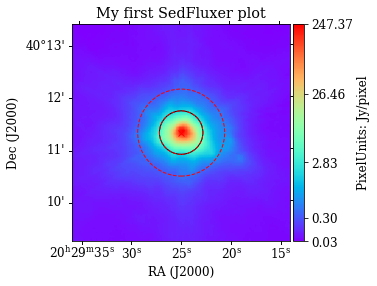

In [5]:
AFGL2591_H70_gt.plot(cmap='rainbow',percent=100.0,stretch='log',
                     colorbar=True,aperture_color='black',annulus_color='red',
                     plot_mask=False,title='My first SedFluxer plot',figname=None)

# Getting the optimal aperture

The example above just assumes an aperture radius by eye to perform aperture photometry. While this may be ok for preliminary testing, it is difficult to reproduce. We have developed an algorithm that calculates the optimal aperture (see `sedcreator` documentation). Very briefly the algorithm retrieves the aperture size that gets most of the flux minimising background noise. This algorithm is encapsulated in the function `get_optimal_aperture()` and its usage is as follows (using the fluxer object and coordinates from above):

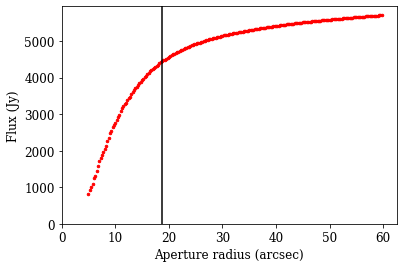

The optimal aperture is  18.75  arcsec


In [6]:
AFGL2591_opt_aper = AFGL2591_H70_fluxer.get_optimal_aperture(central_coords=AFGL2591_coords,
                                                             ap_inner=5.0,ap_outer=60.0,step_size=0.25,
                                                             aper_increase=1.3,threshold=1.1,profile_plot=True)

print('The optimal aperture is ',AFGL2591_opt_aper,' arcsec')

We can now see how it looks with the optimal aperture, note that is slightly smaller than the one chosen (arbitrarily) by eye.

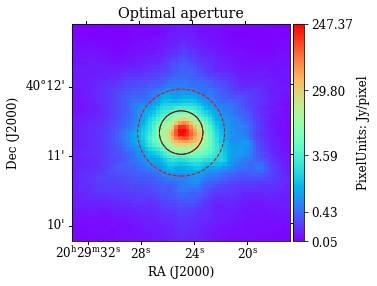

In [7]:
AFGL2591_H70_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None).plot(cmap='rainbow',title='Optimal aperture')

# Second example measuring several fluxes and constructing the SED for AFGL2591

Following the same workflow as for the first example, let's measure fluxes for all images in the **AFGL2591_data** folder. Needless to say that this can be done more efficiently, but let's approach it in a pedagogical way.

Since we have three main telescopes being used in this example, Spitzer, SOFIA, and Herschel; let's divide it in three. We are going to use the same central coordinates and optimal aperture calculated above for all images. We are going to print the info an plot the image for just one image from each telescope to make the example manageable.

In this example we also estimate an error for each measurement. In this example, we are considering that the background dominates the uncertainties in our measurements and we are calculating percentage errors. We also consider that the error should be at least 10%, so if it is below, we still consider 10%.

## Spitzer

The aperture used is 18.75 arcsec
pixel scale is 0.6 arcsec/pixel
~ 31.249 pixels are used for the aperture radius
units in the image are: MJy/sr
Observing date: 2007-07-05 08:12:45.043
Wavelength: 8.0
############################
Flux bkg sub 308.6063570167686 Jy
Flux         313.0629445690579 Jy
Background   4.456587552289307 Jy
############################


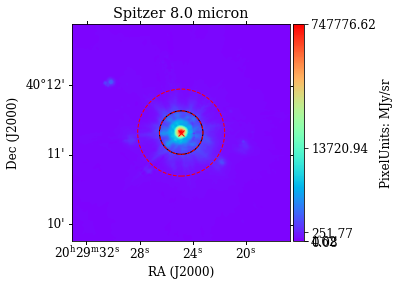

In [8]:
#Spitzer 3.6 micron
AFGL2591_S36_fits = pyfits.open('AFGL2591_data/AFGL2591_Spitzer_36.fits')

#note that for Spitzer the data is in the first extension
AFGL2591_S36_fluxer = SedFluxer(AFGL2591_S36_fits[0])

AFGL2591_S36_gt = AFGL2591_S36_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_S36_flux_bkg,AFGL2591_S36_flux=AFGL2591_S36_gt.value #Jy
AFGL2591_S36_error = np.array([AFGL2591_S36_flux/AFGL2591_S36_flux_bkg - 1.0])
AFGL2591_S36_error[AFGL2591_S36_error<0.1]=0.1
AFGL2591_S36_lambda = 3.6 #micron

#Spitzer 4.5 micron
AFGL2591_S45_fits = pyfits.open('AFGL2591_data/AFGL2591_Spitzer_45.fits')

#note that for Spitzer the data is in the first extension
AFGL2591_S45_fluxer = SedFluxer(AFGL2591_S45_fits[0])

AFGL2591_S45_gt = AFGL2591_S45_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_S45_flux_bkg,AFGL2591_S45_flux=AFGL2591_S45_gt.value #Jy
AFGL2591_S45_error = np.array([AFGL2591_S45_flux/AFGL2591_S45_flux_bkg - 1.0])
AFGL2591_S45_error[AFGL2591_S45_error<0.1]=0.1
AFGL2591_S45_lambda = 4.5 #micron

#Spitzer 5.8 micron
AFGL2591_S58_fits = pyfits.open('AFGL2591_data/AFGL2591_Spitzer_58.fits')

#note that for Spitzer the data is in the first extension
AFGL2591_S58_fluxer = SedFluxer(AFGL2591_S58_fits[0])

AFGL2591_S58_gt = AFGL2591_S58_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_S58_flux_bkg,AFGL2591_S58_flux=AFGL2591_S58_gt.value #Jy
AFGL2591_S58_error = np.array([AFGL2591_S58_flux/AFGL2591_S58_flux_bkg - 1.0])
AFGL2591_S58_error[AFGL2591_S58_error<0.1]=0.1
AFGL2591_S58_lambda = 5.8 #micron

#Spitzer 8.0 micron
AFGL2591_S80_fits = pyfits.open('AFGL2591_data/AFGL2591_Spitzer_80.fits')

#note that for Spitzer the data is in the first extension
AFGL2591_S80_fluxer = SedFluxer(AFGL2591_S80_fits[0])

AFGL2591_S80_gt = AFGL2591_S80_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_S80_flux_bkg,AFGL2591_S80_flux=AFGL2591_S80_gt.value #Jy
AFGL2591_S80_error = np.array([AFGL2591_S80_flux/AFGL2591_S80_flux_bkg - 1.0])
AFGL2591_S80_error[AFGL2591_S80_error<0.1]=0.1
AFGL2591_S80_lambda = 8.0 #micron

AFGL2591_S80_gt.info
AFGL2591_S80_gt.plot(cmap='rainbow',title='Spitzer 8.0 micron')

## SOFIA

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


The aperture used is 18.75 arcsec
pixel scale is 0.768 arcsec/pixel
~ 24.414 pixels are used for the aperture radius
units in the image are: Jy/pix
Observing date: 2018-09-08T06:46:11.911
Wavelength: 37.1um
############################
Flux bkg sub 3196.318628553757 Jy
Flux         3223.905702077269 Jy
Background   27.587073523511663 Jy
############################


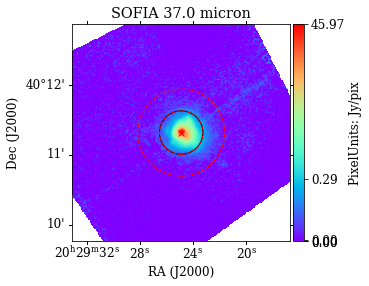

In [9]:
#SOFIA 19 micron
AFGL2591_SO19_fits = pyfits.open('AFGL2591_data/AFGL2591_SOFIA_19.fits')

#note that for SOFIA the data is in the first extension
AFGL2591_SO19_fluxer = SedFluxer(AFGL2591_SO19_fits[0])

AFGL2591_SO19_gt = AFGL2591_SO19_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_SO19_flux_bkg,AFGL2591_SO19_flux=AFGL2591_SO19_gt.value #Jy
AFGL2591_SO19_error = np.array([AFGL2591_SO19_flux/AFGL2591_SO19_flux_bkg - 1.0])
AFGL2591_SO19_error[AFGL2591_SO19_error<0.1]=0.1
AFGL2591_SO19_lambda = 19.2 #micron

#SOFIA 31 micron
AFGL2591_SO31_fits = pyfits.open('AFGL2591_data/AFGL2591_SOFIA_31.fits')

#note that for SOFIA the data is in the first extension
AFGL2591_SO31_fluxer = SedFluxer(AFGL2591_SO31_fits[0])

AFGL2591_SO31_gt = AFGL2591_SO31_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_SO31_flux_bkg,AFGL2591_SO31_flux=AFGL2591_SO31_gt.value #Jy
AFGL2591_SO31_error = np.array([AFGL2591_SO31_flux/AFGL2591_SO31_flux_bkg - 1.0])
AFGL2591_SO31_error[AFGL2591_SO31_error<0.1]=0.1
AFGL2591_SO31_lambda = 31.5 #micron

#SOFIA 37 micron
AFGL2591_SO37_fits = pyfits.open('AFGL2591_data/AFGL2591_SOFIA_37.fits')

#note that for SOFIA the data is in the first extension
AFGL2591_SO37_fluxer = SedFluxer(AFGL2591_SO37_fits[0])

AFGL2591_SO37_gt = AFGL2591_SO37_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_SO37_flux_bkg,AFGL2591_SO37_flux=AFGL2591_SO37_gt.value #Jy
AFGL2591_SO37_error = np.array([AFGL2591_SO37_flux/AFGL2591_SO37_flux_bkg - 1.0])
AFGL2591_SO37_error[AFGL2591_SO37_error<0.1]=0.1
AFGL2591_SO37_lambda = 37.0 #micron

AFGL2591_SO37_gt.info
AFGL2591_SO37_gt.plot(cmap='rainbow',title='SOFIA 37.0 micron')

## Herschel

The aperture used is 18.75 arcsec
pixel scale is 14.0 arcsec/pixel
~ 1.339 pixels are used for the aperture radius
units in the image are: MJy/sr
Regarding observing time:
You are probably using HERSCHEL, look at the first extension of the header
Regarding wavelength:
You are probably using HERSCHEL or ALMA, look at the first extension of the header
############################
Flux bkg sub 25.49940584821297 Jy
Flux         45.07145817571137 Jy
Background   19.5720523274984 Jy
############################


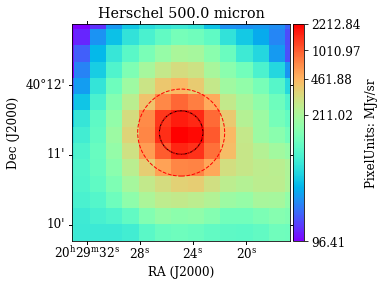

In [10]:
#Herschel 70 micron
AFGL2591_H70_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_70.fits')

AFGL2591_H70_fluxer = SedFluxer(AFGL2591_H70_fits[1])

AFGL2591_H70_gt = AFGL2591_H70_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_H70_flux_bkg,AFGL2591_H70_flux=AFGL2591_H70_gt.value #Jy
AFGL2591_H70_error = np.array([AFGL2591_H70_flux/AFGL2591_H70_flux_bkg - 1.0])
AFGL2591_H70_error[AFGL2591_H70_error<0.1]=0.1
AFGL2591_H70_lambda = 70.0 #micron

#Herschel 160 micron
AFGL2591_H160_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_160.fits')

AFGL2591_H160_fluxer = SedFluxer(AFGL2591_H160_fits[1])

AFGL2591_H160_gt = AFGL2591_H160_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_H160_flux_bkg,AFGL2591_H160_flux=AFGL2591_H160_gt.value #Jy
AFGL2591_H160_error = np.array([AFGL2591_H160_flux/AFGL2591_H160_flux_bkg - 1.0])
AFGL2591_H160_error[AFGL2591_H160_error<0.1]=0.1
AFGL2591_H160_lambda = 160.0 #micron

#Herschel 250 micron
AFGL2591_H250_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_250.fits')

AFGL2591_H250_fluxer = SedFluxer(AFGL2591_H250_fits[1])

AFGL2591_H250_gt = AFGL2591_H250_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_H250_flux_bkg,AFGL2591_H250_flux=AFGL2591_H250_gt.value #Jy
AFGL2591_H250_error = np.array([AFGL2591_H250_flux/AFGL2591_H250_flux_bkg - 1.0])
AFGL2591_H250_error[AFGL2591_H250_error<0.1]=0.1
AFGL2591_H250_lambda = 250.0 #micron

#Herschel 350 micron
AFGL2591_H350_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_350.fits')

AFGL2591_H350_fluxer = SedFluxer(AFGL2591_H350_fits[1])

AFGL2591_H350_gt = AFGL2591_H350_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_H350_flux_bkg,AFGL2591_H350_flux=AFGL2591_H350_gt.value #Jy
AFGL2591_H350_error = np.array([AFGL2591_H350_flux/AFGL2591_H350_flux_bkg - 1.0])
AFGL2591_H350_error[AFGL2591_H350_error<0.1]=0.1
AFGL2591_H350_lambda = 350.0 #micron

#Herschel 350 micron
AFGL2591_H500_fits = pyfits.open('AFGL2591_data/AFGL2591_Herschel_500.fits')

AFGL2591_H500_fluxer = SedFluxer(AFGL2591_H500_fits[1])

AFGL2591_H500_gt = AFGL2591_H500_fluxer.get_flux(central_coords=AFGL2591_coords,
                                               aper_rad=AFGL2591_opt_aper,
                                               inner_annu=1.0*AFGL2591_opt_aper,
                                               outer_annu=2.0*AFGL2591_opt_aper,
                                               mask=None)

AFGL2591_H500_flux_bkg,AFGL2591_H500_flux=AFGL2591_H500_gt.value #Jy
AFGL2591_H500_error = np.array([AFGL2591_H500_flux/AFGL2591_H500_flux_bkg - 1.0])
AFGL2591_H500_error[AFGL2591_H500_error<0.1]=0.1
AFGL2591_H500_lambda = 500.0 #micron

AFGL2591_H500_gt.info
AFGL2591_H500_gt.plot(cmap='rainbow',title='Herschel 500.0 micron')

## Plotting everything together

Now that we have measured the fluxes for our images, let's put them all together and plot them

In [11]:
AFGL2591_ALL_flux_bkg = np.array([AFGL2591_S36_flux_bkg,AFGL2591_S45_flux_bkg,AFGL2591_S58_flux_bkg,AFGL2591_S80_flux_bkg,
                                  AFGL2591_SO19_flux_bkg,AFGL2591_SO31_flux_bkg,AFGL2591_SO37_flux_bkg,
                                  AFGL2591_H70_flux_bkg,AFGL2591_H160_flux_bkg,AFGL2591_H250_flux_bkg,AFGL2591_H350_flux_bkg,AFGL2591_H500_flux_bkg])

AFGL2591_ALL_error = np.array([AFGL2591_S36_error,AFGL2591_S45_error,AFGL2591_S58_error,AFGL2591_S80_error,
                               AFGL2591_SO19_error,AFGL2591_SO31_error,AFGL2591_SO37_error,
                               AFGL2591_H70_error,AFGL2591_H160_error,AFGL2591_H250_error,AFGL2591_H350_error,AFGL2591_H500_error])

#Because of the way we constructed the individual errors we need to flatten it now
AFGL2591_ALL_error = AFGL2591_ALL_error.flatten()

AFGL2591_ALL_lambda = np.array([AFGL2591_S36_lambda,AFGL2591_S45_lambda,AFGL2591_S58_lambda,AFGL2591_S80_lambda,
                                AFGL2591_SO19_lambda,AFGL2591_SO31_lambda,AFGL2591_SO37_lambda,
                                AFGL2591_H70_lambda,AFGL2591_H160_lambda,AFGL2591_H250_lambda,AFGL2591_H350_lambda,AFGL2591_H500_lambda])

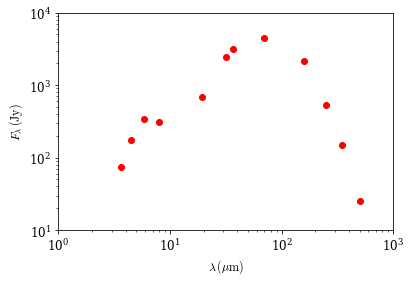

In [12]:
plt.figure(figsize=(6,4))
plt.errorbar(AFGL2591_ALL_lambda,AFGL2591_ALL_flux_bkg,yerr=AFGL2591_ALL_error,fmt='ro')
#errors are fairly small so they are within the marker
plt.xlim(1.0e0,1.0e3)
plt.ylim(1.0e1,1.0e4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda\,(\mathrm{\mu m})$')
plt.ylabel(r'$F_\lambda\,(\mathrm{Jy})$')
plt.show()

<font size="4">The above arrays are some of the inputs you will need to use `SedFitter` and fit the measured fluxes ([see example notebook](https://github.com/fedriani/sedcreator/blob/main/examples/SedFitter_example.ipynb))
    
</font>

---
---
<font size="4">Author: R. Fedriani (Chalmers University of Technology)

Last update: 25 July 2022</font>

---